In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

def add_to_path(dir_path):
    if dir_path not in sys.path:
        sys.path.insert(0, dir_path)
        
add_to_path('src')

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from PIL import Image

import matplotlib.pyplot as plt

In [123]:
def sample_gaussean(mean, loc):
    dist = torch.distributions.normal.Normal(mean, loc)
    return dist.rsample()

def sample_gaussean_sp(mean, log_loc):
    return sample_gaussean(mean, torch.nn.functional.softplus(log_loc))

def sample_bernoulli(p_logits, hard=True, clamp=False, temperature=1):
    dist = torch.distributions.RelaxedBernoulli(temperature=1, logits=p_logits)
    obj_prob = dist.rsample().to(device=p_logits.device)
    if hard:
        obj_prob_hard = (obj_prob >= 0.5).to(dtype=torch.float)
        return (obj_prob_hard - obj_prob).detach() + obj_prob, obj_prob
    else:
        return obj_prob, obj_prob
    
def sample_obj_pres(p_logits, st=True, clamp=False, eps=1e-20):
    if clamp:
        p_logits = torch.clamp(p_logits, -10., 10.)
    
    u = torch.rand(p_logits.size())
    noise = torch.log(u + eps) - torch.log(1.0 - u + eps)
    obj_pre_sigmoid = (p_logits + noise)
    obj_prob = torch.sigmoid(obj_pre_sigmoid)

    if st:
        obj_prob_hard = (obj_prob >= 0.5).to(p_logits.dtype)
        return (obj_prob_hard - obj_prob).detach() + obj_prob, obj_prob
    else:
        return obj_prob, obj_prob

# Work

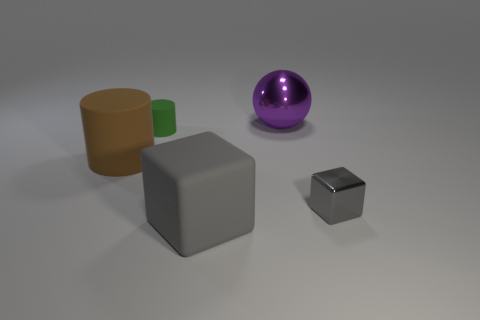

In [58]:
GLIMPSE_SHAPE = (16, 16)
img = Image.open('/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/images/val/CLEVR_val_000000.png')
img = img.convert('RGB')
x = T.functional.to_tensor(img).unsqueeze(0)
img

## Foreground Inference

In [116]:
from modules import ImgEncoder

bsz, C, H, W = x.size()
image_shape = torch.tensor((H, W), dtype=torch.float, device=x.device)

encoder = ImgEncoder()
img_feats = encoder(x)
Hp, Wp = img_feats.size()[-2:]
fmap_shape = torch.tensor((Hp, Wp), dtype=torch.float, device=x.device)
ch, cw = image_shape / fmap_shape #  pseudo-receptive field

z_dim = 1 + 2 + 4 + 4 # z_pres, z_depth, z_scale, z_shift
znet = nn.Conv2d(
    in_channels=64,
    out_channels=z_dim,
    kernel_size=(1, 1),
)
Z = znet(img_feats).permute(0, 2, 3, 1)
(pres_p_logits, depth_mean, depth_log_std, scale_mean, 
    scale_log_std, center_shift_mean, center_shift_log_std) = Z.split([1, 1, 1, 2, 2, 2, 2], dim=-1)

In [125]:
print(pres_p_logits.size())
obj_pres, obj_pres_prob = sample_bernoulli(pres_p_logits, hard=True, temperature=1) # (bsz, Hp, Wp, 1), # (bsz, Hp, Wp, 1)
z_pres = obj_pres
# SPACE mentioned using softplus activation for std-dev
z_depth = sample_gaussean(depth_mean, nn.functional.softplus(depth_log_std)) # (bsz, Hp, Wp, 1)
z_scale = sample_gaussean(scale_mean, nn.functional.softplus(scale_log_std)) # (bsz, Hp, Wp, 2)
z_shift = sample_gaussean(center_shift_mean, nn.functional.softplus(center_shift_log_std)) # (bsz, Hp, Wp, 2)

z_pres.size(), obj_pres_prob.size()

torch.Size([1, 19, 29, 1])


(torch.Size([1, 19, 29, 1]), torch.Size([1, 19, 29, 1]))

In [126]:
z_scale_wrt_anchor = torch.sigmoid(z_scale) # Initial expected value of 0.5
# z_scale_abs: size in pixels, according to SPAIR, using a constant anchor instead of a possible
# variable image size is better
z_scale_abs = z_scale_wrt_anchor * torch.tensor(GLIMPSE_SHAPE)
z_scale_wrt_img = z_scale_abs / image_shape # size in range (0, GLIMPSE_SIZE / IMAGE_SIZE)

# Initial expected value of 0.5, in the center of each fmap cell
z_shift_wrt_fmap = torch.sigmoid(z_shift)
z_shift_wrt_img = z_shift_wrt_fmap / fmap_shape
# ij_grid: coordinate map with values (x, y) in ((0, 1), (0, 1)) where 
# 0 is the left/top-most position of the image and 1 the right/bottom-most
# each coordinate denotes the top-left corner of the projected
# pseudo-receptive field in the original image for each cell of the
# feature map
ij_grid = torch.stack(torch.meshgrid((torch.arange(0, 1, 1 / Hp), torch.arange(0, 1, 1 / Wp))), dim=-1)
z_center_wrt_img = (ij_grid.unsqueeze(0) + z_shift_wrt_img)
# z_center_wrt_img__11: transformed values of centers relative 
# to the image to range (-1, 1) to use with torch.nn.functional.make_grid
z_center_wrt_img__11 = (z_center_wrt_img * 2) - 1

In [127]:
# transformation height and width
theta_h, theta_w = z_scale_wrt_img.view(-1, 2).split(1, -1)
# transformation translation
theta_tx, theta_ty = z_center_wrt_img__11.view(-1, 2).split(1, -1)
# transformation, zero values are crop skewness, for now without skew
theta = torch.cat([theta_w, torch.zeros_like(theta_w), theta_ty, torch.zeros_like(theta_w), theta_h, theta_tx], dim=-1)

_theta = theta.view(-1, 2, 3)
grid = F.affine_grid(_theta, (_theta.size(0), C, *GLIMPSE_SHAPE), align_corners=False)
# repeat each image Hp * Wp times for each cropping
_x = x.unsqueeze(1).expand(-1, Hp * Wp, -1, -1, -1)
_x = _x.view(-1, C, H, W)
xs = F.grid_sample(_x, grid, align_corners=False)

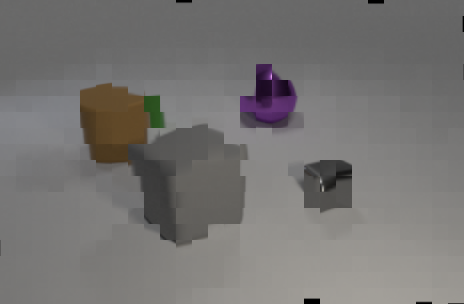

In [128]:
T.functional.to_pil_image(torchvision.utils.make_grid(xs, nrow=29, padding=0))

In [129]:
print(xs.size())

torch.Size([551, 3, 16, 16])


In [179]:
class GlimpseEncoder(nn.Module):
    def __init__(self,
                 num_channels=[3, 16, 32, 32, 64, 128, 256],
                 kernel_sizes=[(3, 3), (4, 4), (3, 3), (4, 4), (4, 4), (4, 4)],
                 strides=[(1, 1), (2, 2), (1, 1), (1, 1), (2, 2), (1, 1)],
                 num_groups=[4, 8, 4, 8, 8, 16],
                 out_proj_dim=64,
                 out_pool='avg',
                ):
        super().__init__()
        self.celu = nn.CELU()
        conv_layers = []
        for i in range(len(num_channels) - 1):
            conv_layers.append(nn.Sequential(
                nn.Conv2d(
                    in_channels=num_channels[i],
                    out_channels=num_channels[i + 1],
                    kernel_size=kernel_sizes[i],
                    stride=strides[i]
                ),
                nn.GroupNorm(num_groups=num_groups[i], num_channels=num_channels[i + 1]),
                self.celu,
            ))
        self.conv_layers = nn.Sequential(*conv_layers)
        self.out_proj = nn.Conv2d(
            in_channels=num_channels[-1],
            out_channels=out_proj_dim,
            kernel_size=(1, 1),
        )
        if out_pool == 'avg':
            self.out_pool = nn.AdaptiveAvgPool2d(1)
        elif out_pool == 'max':
            self.out_pool = nn.AdaptiveMaxPool2d(1)
        else:
            raise ValueError(f'Unknown pooling operation: {out_pool}')
        
    def forward(self, x):
        # return self.out_pool(self.out_proj(self.conv_layers(x)))
        return self.out_proj(self.conv_layers(x))
    
GLIMPSE_SHAPE = (100, 100)
gencoder = GlimpseEncoder()
gencoder(torch.randn(1, 3, *GLIMPSE_SHAPE)).size()

torch.Size([1, 64, 17, 17])

In [183]:
from modules import FG

glimpses_getter = FG(glimpse_shape=(*GLIMPSE_SHAPE,))
glimpses = glimpses_getter.get_glimpses(x)
glimpses.size()

torch.Size([551, 3, 100, 100])

In [184]:
what_params = gencoder(glimpses)
what_params.size()

torch.Size([551, 64, 17, 17])

In [185]:
what_mean, what_log_std = what_params.split((32), dim=1)
what_mean.size(), what_log_std.size()

(torch.Size([551, 32, 17, 17]), torch.Size([551, 32, 17, 17]))

In [186]:
z_what = sample_gaussean_sp(what_mean, what_log_std)
z_what.size()

torch.Size([551, 32, 17, 17])

In [187]:
z_pres.size()

torch.Size([1, 19, 29, 1])

In [174]:
from collections import OrderedDict

class GlimpseDecoder(nn.Module):
    def __init__(self,
                 conv_channels=[256, 128, 128, 64, 32, 16],
                 conv_strides=[1, 1, 1, 1, 3, 1],
                 conv_group_norms=[16, 16, 16, 8, 8],
                 conv_ks=[1, 1, 3, 3, 3],
                 sub_conv_factors=[2, 2, 2, 2, 2],
                 sub_conv_channels=[128, 128, 64, 32, 16, 32], # last item for first element edge case
                 sub_conv_strides=[1, 1, 1, 1, 1],
                 sub_conv_group_norms=[16, 16, 8, 8, 4],
                 out_proj_dim=16,
                 out_proj_ks=3,
                 out_proj_stride=1,
                ):
        super().__init__()
        
        self.celu = nn.CELU()
        conv_layers = OrderedDict([])
        
        for i in range(len(conv_channels)):
            conv_layers[f'group_conv{i}'] = nn.Sequential(OrderedDict([
                    (f'conv{i}', nn.Sequential(
                        nn.Conv2d(
                            in_channels=sub_conv_channels[i - 1],
                            out_channels=conv_channels[i],
                            kernel_size=conv_ks[i],
                            stride=conv_strides[i],
                        ),
                        nn.GroupNorm(num_groups=conv_group_norms[i], num_channels=conv_channels[i]),
                        self.celu,
                    )),
                    (f'sub_conv{i}', nn.Sequential(
                        nn.Conv2d(
                            in_channels=conv_channels[i],
                            out_channels=sub_conv_channels[i] * sub_conv_factors[i] ** 2,
                            stride=sub_conv_strides[i],
                            kernel_size=1,
                        ),
                        nn.PixelShuffle(sub_conv_factors[i]),
                        nn.GroupNorm(num_groups=sub_conv_group_norms[i], num_channels=sub_conv_channels[i]),
                        self.celu,
                    )),
                ]))
                    
        self.conv_layers = nn.Sequential(conv_layers)
            
    def forward(self, x):
        return self.conv_layers(x)
    
gdecoder = GlimpseDecoder()
gdecoder(z_what).size()

torch.Size([551, 16, 2, 2])

In [171]:
gdecoder

GlimpseDecoder(
  (celu): CELU(alpha=1.0)
  (conv_layers): Sequential(
    (group_conv0): Sequential(
      (conv0): Sequential(
        (0): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): GroupNorm(16, 256, eps=1e-05, affine=True)
        (2): CELU(alpha=1.0)
      )
      (sub_conv0): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
        (1): PixelShuffle(upscale_factor=2)
        (2): GroupNorm(16, 128, eps=1e-05, affine=True)
        (3): CELU(alpha=1.0)
      )
    )
    (group_conv1): Sequential(
      (conv1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): GroupNorm(16, 128, eps=1e-05, affine=True)
        (2): CELU(alpha=1.0)
      )
      (sub_conv1): Sequential(
        (0): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1))
        (1): PixelShuffle(upscale_factor=2)
        (2): GroupNorm(16, 128, eps=1e-05, affine=True)
        (3): CELU(alpha=1.0)
      )
    )
    (group_conv2): S

In [172]:
class GlimpseDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=256, stride=1, kernel_size=1)
        self.gn1 = nn.GroupNorm(num_groups=16, num_channels=256)
        self.celu1 = nn.CELU()
        
        self.sub_conv1 = nn.Conv2d(in_channels=256, out_channels=128 * 2 ** 2, stride=1, kernel_size=1)
        self.sub_pf1 = nn.PixelShuffle(upscale_factor=2)
        self.sub_gn1 = nn.GroupNorm(num_groups=16, num_channels=128)
        self.sub_celu1 = nn.CELU()
    
    def forward(self, x):
        x = self.celu1(self.gn1(self.conv1(x)))
        print(x.size())
        
        x = self.sub_conv1(x)
        print(x.size())
        x = self.sub_pf1(x)
        print(x.size())
        x = self.sub_celu1(self.sub_gn1(x))
        print(x.size())
        
        return x 
    
gdecoder = GlimpseDecoder()
gdecoder(z_what).size()

torch.Size([551, 256, 1, 1])
torch.Size([551, 512, 1, 1])
torch.Size([551, 128, 2, 2])
torch.Size([551, 128, 2, 2])


torch.Size([551, 128, 2, 2])

# Working Modules

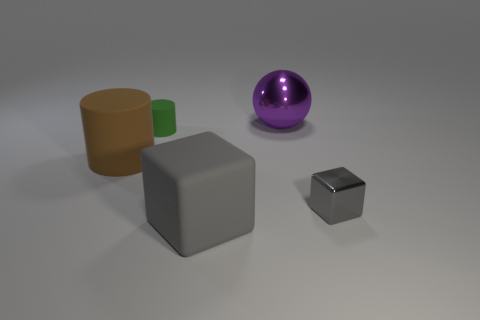

In [24]:
from modules import FG

fg = FG()
img = Image.open('/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/images/val/CLEVR_val_000000.png')
img = img.convert('RGB')

img

19 29 torch.Size([1, 64, 19, 29])
torch.Size([19, 29, 2])


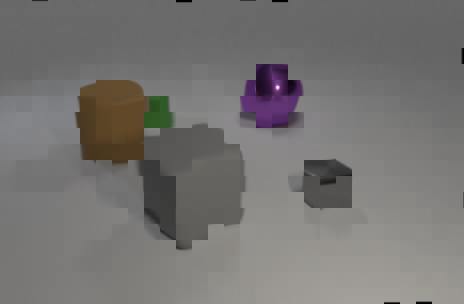

In [27]:
x = T.functional.to_tensor(img).unsqueeze(0)
xs = fg(x)
T.functional.to_pil_image(torchvision.utils.make_grid(xs, nrow=29, padding=0))

# Spatial Transformer

In [60]:
import torch.nn.functional as F
from torch.utils import data
from PIL import Image

In [38]:
img = Image.open('/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/images/val/CLEVR_val_000000.png')
img = img.convert('RGB')
x = np.array(img)
tensor_x = torch.Tensor(x)
my_dataset = data.TensorDataset(transforms.functional.to_tensor(np.array(img))[None])

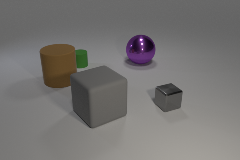

In [92]:
IMG_SIZE = (3, 160, 240)
_img = img.resize(IMG_SIZE[-1:0:-1])
x = torchvision.transforms.functional.to_tensor(_img).unsqueeze(0)
_img

theta
tensor([[[1.0000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000]]])
grid size
torch.Size([1, 80, 120, 2])


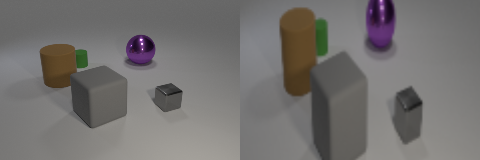

In [216]:
h, w = 0.5, 1
tx, ty = 0, 0
theta = torch.tensor([w, 0, tx, 0, h, tw], dtype=torch.float32)
theta = theta.view(1, 2, 3)
print('theta')
print(theta)
grid = F.affine_grid(theta, (1, 3, 80, 120), align_corners=True)
print('grid size')
print(grid.size())
_xs = F.grid_sample(x, grid, align_corners=True)
_xs_upsampled = F.interpolate(_xs, size=x.size()[2:], align_corners=True, mode='bilinear')
cat_images = torch.cat((x[0],_xs_upsampled[0]), dim=-1)
torchvision.transforms.functional.to_pil_image(cat_images)

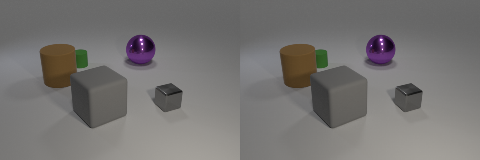

In [104]:
torchvision.transforms.functional.to_pil_image(torch.cat((x[0],_xs[0]), dim=-1))